# Introduction: TSC model performace eavluation

The purpose of this notebook is to assess the efficacy of model training. Given auPRC values over several bins, Jensen-Shannon distances, Pearson correlation values of counts, and predictions across putative enhancers we will assess the model  performance.

# Computational Setup

In [1]:
# Configurations
import warnings;warnings.filterwarnings("ignore")
from tensorflow.python.util import deprecation; deprecation._PRINT_DEPRECATION_WARNINGS = False

#Modules
import os
import sys
import yaml
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotnine
from glob import glob
from plotnine import *
from itertools import product, compress
from pybedtools import BedTool
from keras import backend as K
from bpnet.utils import read_json, create_tf_session
from bpnet.dataspecs import DataSpec
from bpnet.datasets import StrandedProfile
from bpnet.extractors import StrandedBigWigExtractor
from bpnet.BPNet import BPNetSeqModel
from bpnet.metrics import eval_profile

#Setup
os.chdir('/n/projects/kd2200/publication/bpnet/analysis/')
create_tf_session('0')
%matplotlib inline

# #Variables
dataspec = DataSpec.load(f'/n/projects/kd2200/publication/bpnet/model/dataspec.yaml_default_fold_5/dataspec.yml')
config = read_json(f'/n/projects/kd2200/publication/bpnet/model/dataspec.yaml_default_fold_5/config.gin.json')
tasks = list(dataspec.task_specs.keys())
excl_chromosomes = config['bpnet_data.exclude_chr']
incl_chromosomes = config['bpnet_data.valid_chr']


Using TensorFlow backend.


2023-12-20 16:47:58,752 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

2023-12-20 16:47:59,231 [INFO] Note: detected 80 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2023-12-20 16:47:59,233 [INFO] Note: NumExpr detected 80 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-12-20 16:47:59,234 [INFO] NumExpr defaulting to 8 threads.


2023-12-20 16:48:00,805 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/bpnet-0.0.21-py3.6.egg/bpnet/utils.py:360: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



2023-12-20 16:48:00,812 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/bpnet-0.0.21-py3.6.egg/bpnet/utils.py:363: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
with open(r'/n/projects/kd2200/publication/bpnet/analysis/data/yml/tsc_model_macs2_bias_replicates.yml') as file:
    rep_path_dict = yaml.load(file, Loader=yaml.FullLoader)
[[[os.path.exists(v3) for k3,v3 in v2.items()] for k2,v2 in v1.items()] for k1,v1 in rep_path_dict.items()]

[[[True, True], [True, True]],
 [[True, True], [True, True]],
 [[True, True], [True, True]],
 [[True, True], [True, True]],
 [[True, True], [True, True]]]

# Convert IDR-reproducible files to bed files

In [3]:
%%script false --no-raise-error
!parallel -j 8 Rscript /n/projects/kd2200/publication/bpnet/analysis/scripts/idr_to_bed.R -i {} -b  /n/projects/kd2200/publication/bpnet/analysis/data/mm10.blacklist.bed -g BSgenome.Mmusculus.UCSC.mm10 -w 1500 -o /n/projects/kd2200/publication/analysis/data/bed\`basename {} .txt\`.bed ::: /n/projects/kd2200/publication/bpnet/analysis/data/pairwise_idr*.txt

In [4]:
!wc -l /n/projects/kd2200/publication/bpnet/analysis/data/bed/*

wc: /n/projects/kd2200/publication/bpnet/analysis/data/bed/mtsc_cdx2_6_vs_7_nexus_idr.bed: Permission denied
wc: /n/projects/kd2200/publication/bpnet/analysis/data/bed/mtsc_gata3_1_vs_2_nexus_idr.bed: Permission denied
wc: /n/projects/kd2200/publication/bpnet/analysis/data/bed/mtsc_tead4_1_vs_2_nexus_idr.bed: Permission denied
wc: /n/projects/kd2200/publication/bpnet/analysis/data/bed/mtsc_tfap2c_6_vs_7_nexus_idr.bed: Permission denied
  17479 /n/projects/kd2200/publication/bpnet/analysis/data/bed/mtsc_yap1_1_vs_2_nexus_idr.bed
  17479 total


## Helper functions

### Jensen-Shannon distance


Jensen-Shannon divergence is a method of differentiating two probability distributions. It is a symmetric and smoothed version of the KL divergence and can be used as a divergence (distance is you take the sqrt(div)) metric. This means it is less sensitive than KL div. to small changes in distribution differences.

Read the following articles for more information about it differs from KL divergence: https://medium.com/datalab-log/measuring-the-statistical-similarity-between-two-samples-using-jensen-shannon-and-kullback-leibler-8d05af514b15 https://dit.readthedocs.io/en/latest/measures/divergences/jensen_shannon_divergence.html

In [3]:
def compute_jsdist_between_tracks(p, q, q_pseudocounts = None):
    
    assert len(p.shape)==3, "Input arrays need to be [region x position x strand]."
    if q_pseudocounts is not None:
        q = q + q_pseudocounts
    
    #Check that p and q are probability distributions
    p_prob = p/p.sum(axis=(1), keepdims=True)
    q_prob = q/q.sum(axis=(1), keepdims=True)
    m_prob = np.mean(np.stack([p_prob,q_prob]), axis = 0)

    #Compute entropy of probabilities relative to m (the average between the two probabilities)
    pm = np.nansum(p_prob*np.log2(p_prob/m_prob), axis = 1)
    qm = np.nansum(q_prob*np.log2(q_prob/m_prob), axis = 1)

    #Compute Jensen-Shannon distance
    jsdist = np.sqrt((pm + qm)/2)

    #Average between strands
    if len(jsdist.shape)==2:
        return np.mean(jsdist, axis = 1)
    else:
        return jsdist #Return vector of Jensen-Shannon distances across regions

To read the evaluation metrics computed in the training step of BPNet, we need to parse through a `.json` file.

In [4]:
def collect_eval_metrics(eval_path):
    from bpnet.utils import read_json
    eval_dict = read_json(eval_path)
    df = pd.DataFrame([(k,k1,v1) for k,v in eval_dict.items() for k1,v1 in v.items()], columns = ['dataset','id','value'])
    df = df.replace({'counts/':'counts//'}, regex=True) 
    df[['task','head','binsize','metric']] = df.id.str.split('/', expand=True) 
    df[(df['metric']=='auprc') | (df['metric']=='spearmanr')]
    return(df)

# Comparison of the model with observed/replicate quality metrics 

Load the model into this session.

In [5]:
K.clear_session()
model = BPNetSeqModel.from_mdir(f'/n/projects/kd2200/publication/bpnet/model/dataspec.yaml_default_fold_5/')

2023-12-20 16:48:01,036 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.



2023-12-20 16:48:01,039 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



2023-12-20 16:48:01,046 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



2023-12-20 16:48:09,160 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



2023-12-20 16:48:09,189 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



2023-12-20 16:48:09,813 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



2023-12-20 16:48:09,817 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



2023-12-20 16:48:09,819 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.



2023-12-20 16:48:09,975 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



2023-12-20 16:48:10,230 [WARNING] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



2023-12-20 16:48:11,169 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



2023-12-20 16:48:11,460 [WARNING] From /home/kd2200/anaconda3/envs/bpnet/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



## Collect coverage from predictions, observed, and replicate values

Here, we want to compare replicate and metapeak quality metrics with the models trained below. Keep in mind that we will remove regions not associated with each task in order to ensure that we aren't predicting regions that are not of interest for particular tasks.

First, collect data and regions for coverage extraction.

In [6]:
#Get data loader specs for validation set
dl = StrandedProfile(dataspec, 
                     incl_chromosomes = incl_chromosomes, 
                     excl_chromosomes = excl_chromosomes, 
                     peak_width=config['bpnet_data.peak_width'],
                     seq_width=config['bpnet_data.seq_width'],
                     shuffle=False)
data = dl.load_all(num_workers=8)

#Get regions for validation set 
regions_df = pd.DataFrame([list(data['metadata']['range']['chr']),
                              list(data['metadata']['range']['start']),
                              list(data['metadata']['range']['end']),
                              list(data['metadata']['range']['strand'])]).transpose()
regions_bed = BedTool.from_dataframe(regions_df)

100%|██████████| 1200/1200 [00:56<00:00, 21.43it/s]


Collect observed, replicate and metpeak coverage from the loaded data. Formats should be `{task -> [region x seqwidth x 2]}`.

In [7]:
#Get obs  values
y_obs = data['targets']
y_pred_seqmodel = model.seqmodel.predict(data['inputs']['seq']) #Provides counts and logits
y_pred = {task: y_pred_seqmodel[f'{task}/profile'] * np.exp(y_pred_seqmodel[f'{task}/counts'][:, np.newaxis]) 
                for task in model.tasks} #Provides counts*profile


In [8]:
rep_path_dict

{'cdx2': {'rep1': {'pos': '/n/projects/kd2200/analysis/BPNet/cegkttyz_tsc_bpnet/grid_search/final_cttgy_tsc_model/bpnet/bw/individual/mtsc_cdx2_nexus_h32_6_positive.bw',
   'neg': '/n/projects/kd2200/analysis/BPNet/cegkttyz_tsc_bpnet/grid_search/final_cttgy_tsc_model/bpnet/bw/individual/mtsc_cdx2_nexus_h32_6_negative.bw'},
  'rep2': {'pos': '/n/projects/kd2200/analysis/BPNet/cegkttyz_tsc_bpnet/grid_search/final_cttgy_tsc_model/bpnet/bw/individual/mtsc_cdx2_nexus_h32_7_positive.bw',
   'neg': '/n/projects/kd2200/analysis/BPNet/cegkttyz_tsc_bpnet/grid_search/final_cttgy_tsc_model/bpnet/bw/individual/mtsc_cdx2_nexus_h32_7_negative.bw'}},
 'gata3': {'rep1': {'pos': '/n/projects/kd2200/analysis/BPNet/cegkttyz_tsc_bpnet/grid_search/final_cttgy_tsc_model/bpnet/bw/individual/mtsc_gata3_nexus_h32_1_positive.bw',
   'neg': '/n/projects/kd2200/analysis/BPNet/cegkttyz_tsc_bpnet/grid_search/final_cttgy_tsc_model/bpnet/bw/individual/mtsc_gata3_nexus_h32_1_negative.bw'},
  'rep2': {'pos': '/n/project

In [9]:
# Extract replicate values for each region for comparison
rep1_obs = {t: np.stack([StrandedBigWigExtractor(bigwig_file = rep_path_dict[t]['rep1']['pos']).extract(regions_bed),
                         StrandedBigWigExtractor(bigwig_file = rep_path_dict[t]['rep1']['neg']).extract(regions_bed)], axis = 2) 
            for t in tqdm(tasks)}
rep2_obs = {t: np.stack([StrandedBigWigExtractor(bigwig_file = rep_path_dict[t]['rep2']['pos']).extract(regions_bed),
                         StrandedBigWigExtractor(bigwig_file = rep_path_dict[t]['rep2']['neg']).extract(regions_bed)], axis = 2) 
            for t in tqdm(tasks)}

100%|██████████| 5/5 [09:25<00:00, 113.10s/it]


In [10]:
#Generate metapeak from profiles
y_mp_2d = {t: np.mean(y_obs[f'{t}/profile'], axis = 0) for t in tasks}
y_mp = {t: np.stack([y_mp_2d[t] for i in range(y_obs[f'{t}/profile'].shape[0])], axis = 0) for t in tasks}

Take the absolute value of the replicates introduced because ChIP-nexus bigwigs have the strand information encoded as axes.

In [11]:
rep1_obs = {k: np.abs(v) for k,v in rep1_obs.items()}
rep2_obs = {k: np.abs(v) for k,v in rep2_obs.items()}

# Calculate counts correlations

Keep in mind that the observed counts already have the `log` applied to them based off of the dataloader.

In [12]:
from bpnet.metrics import pearsonr,spearmanr

corr_df = pd.DataFrame()
counts_df = pd.DataFrame()
for task in tqdm(model.tasks):
    #Filtering regions such that they belong to the correct task at hand
    ytrue_logcounts_filtered = np.mean(y_obs[f'{task}/counts']+1, axis = 1)
    ypred_logcounts_filtered = np.mean(y_pred_seqmodel[f'{task}/counts']+1, axis = 1)
    c_df = pd.DataFrame([ytrue_logcounts_filtered, ypred_logcounts_filtered])
    c_df = c_df.transpose()
    c_df.columns = ['obs','pred']
    c_df['task'] = task
    counts_df = counts_df.append(c_df)
    pearson = pearsonr(ytrue_logcounts_filtered, ypred_logcounts_filtered)
    spearman = spearmanr(ytrue_logcounts_filtered, ypred_logcounts_filtered)
    df = pd.DataFrame([pearson, spearman, task]).transpose()
    df.columns = ['pearson_corr','spearman_corr','task']
    corr_df = corr_df.append(df)
corr_df['txt'] = ['corr_s: ' + str(np.round(row.spearman_corr, 2)) for i,row in corr_df.iterrows()]

100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


In [15]:
# Write the DataFrame to a TSV file
counts_df.to_csv("tsv/correlation_counts_df", sep='\t', index=False)
corr_df.to_csv("tsv/correlation_obs_pred_df", sep='\t', index=False)

In [16]:
import seaborn as sns
plotnine.options.figure_size = (6,16)#(16,3)

corr_plot = (ggplot(data = counts_df, mapping = aes('obs','pred'))+
    geom_point(aes(color = 'task'), size = .2)+
    geom_text(data = corr_df, mapping = aes(x = 4, y = 7, label = 'txt'))+
    scale_x_continuous(name = 'log(obs_counts)')+
    scale_y_continuous(name = 'log(pred_counts)')+
    scale_color_manual(values = sns.color_palette('magma', n_colors = len(model.tasks)).as_hex())+
    #facet_grid('. ~ task')+
    facet_grid('task ~ .', scales="free")+
    ggtitle('spearman correlation across validation set')+
    theme_classic())

corr_plot.save(f'/n/projects/kd2200/publication/bpnet/analysis/figures/2_performance_evaluation/corr_valid_regions_fold5_scale_free.png', height = 10, width = 4)
corr_plot.save(f'/n/projects/kd2200/publication/bpnet/analysis/figures/2_performance_evaluation/corr_valid_regions_fold5_scale_free.pdf', height = 10, width = 4)
print(corr_plot)

SyntaxError: invalid syntax (<ipython-input-16-3cf6ba9dd91d>, line 5)

## Calculate replicate and metapeak auPRC 

In [16]:
#Calulcate auPRC values for this model
auprc_df = pd.DataFrame()
for task in tqdm(model.tasks):
    
    #Filtering regions such that they belong to the correct task at hand
    task_idx = np.where(data['metadata']['interval_from_task'] == f'{task}')[0]
    #task_idx = range(y_obs[f'{task}/profile'].shape[0])
        
    #Observed versus predicted signal
    o_vs_p_df = eval_profile(yt = y_obs[f'{task}/profile'][task_idx], yp = y_pred[f'{task}'][task_idx],
                             pos_min_threshold=0.015, neg_max_threshold=0.005,
                             required_min_pos_counts=2.5, binsizes=[1, 2, 4, 10, 20, 50, 100])
    o_vs_p_df['type']='obs_vs_pred'
    
    #Replicate 1 vs replicate 2
    r1_vs_r2_df = eval_profile(yt = rep1_obs[f'{task}'][task_idx], yp = rep2_obs[f'{task}'][task_idx],
                             pos_min_threshold=0.015, neg_max_threshold=0.005,
                               required_min_pos_counts=2.5, binsizes=[1, 2, 4, 10, 20, 50, 100])
    r1_vs_r2_df['type']='rep1_vs_rep2'

    #Observed versus metpeak signal
    o_vs_mp_df = eval_profile(yt = y_obs[f'{task}/profile'][task_idx], yp = y_mp[f'{task}'][task_idx],
                             pos_min_threshold=0.015, neg_max_threshold=0.005,
                               required_min_pos_counts=2.5, binsizes=[1, 2, 4, 10, 20, 50, 100])
    o_vs_mp_df['type']='obs_vs_metapeak'
    
    #Observed versus randomly shuffled signal
    o_vs_r_df = o_vs_p_df.copy()
    o_vs_r_df['auprc'] = o_vs_r_df['random_auprc']
    o_vs_r_df['type']='obs_vs_random'
    
    df = pd.concat([o_vs_p_df, r1_vs_r2_df, o_vs_mp_df, o_vs_r_df]) 
    df['task'] = task
    auprc_df = auprc_df.append(df)

 20%|██        | 1/5 [00:58<03:52, 58.08s/it]

100%|██████████| 5/5 [03:19<00:00, 39.86s/it]


In [17]:
#Calulcate auPRC values for this model
auprc_df = pd.DataFrame()
for task in tqdm(model.tasks):
    
    #Filtering regions such that they belong to the correct task at hand
    task_idx = np.where(data['metadata']['interval_from_task'] == f'{task}')[0]
    #task_idx = range(y_obs[f'{task}/profile'].shape[0])
        
    #Observed versus predicted signal
    o_vs_p_df = eval_profile(yt = y_obs[f'{task}/profile'][task_idx], yp = y_pred[f'{task}'][task_idx],
                             pos_min_threshold=0.015, neg_max_threshold=0.005,
                             required_min_pos_counts=2.5, binsizes=[1, 2, 4, 10, 20, 50, 100])
    o_vs_p_df['type']='obs_vs_pred'
    
    #Replicate 1 vs replicate 2
    r1_vs_r2_df = eval_profile(yt = rep1_obs[f'{task}'][task_idx], yp = rep2_obs[f'{task}'][task_idx],
                             pos_min_threshold=0.015, neg_max_threshold=0.005,
                               required_min_pos_counts=2.5, binsizes=[1, 2, 4, 10, 20, 50, 100])
    r1_vs_r2_df['type']='rep1_vs_rep2'
    
    
    #Observed versus metpeak signal
    o_vs_mp_df = eval_profile(yt = y_obs[f'{task}/profile'][task_idx], yp = y_mp[f'{task}'][task_idx],
                             pos_min_threshold=0.015, neg_max_threshold=0.005,
                               required_min_pos_counts=2.5, binsizes=[1, 2, 4, 10, 20, 50, 100])
    o_vs_mp_df['type']='obs_vs_metapeak'
    
    #Observed versus randomly shuffled signal
    o_vs_r_df = o_vs_p_df.copy()
    o_vs_r_df['auprc'] = o_vs_r_df['random_auprc']
    o_vs_r_df['type']='obs_vs_random'
    
    df = pd.concat([o_vs_p_df, r1_vs_r2_df, o_vs_mp_df, o_vs_r_df]) 
    df['task'] = task
    auprc_df = auprc_df.append(df)

 20%|██        | 1/5 [00:59<03:56, 59.06s/it]

100%|██████████| 5/5 [03:25<00:00, 41.15s/it]


Plot the auPRC values of actual data for reference.

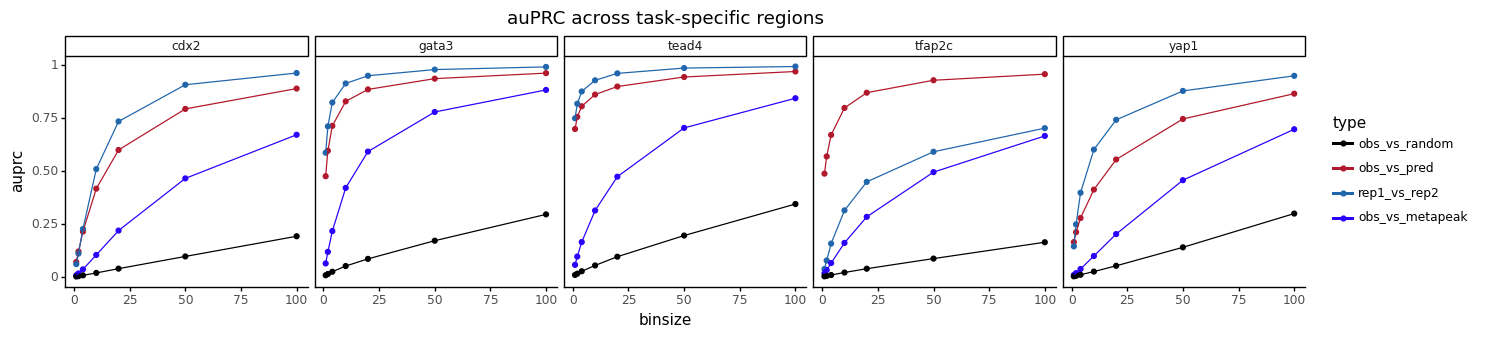

In [18]:
%matplotlib inline
plotnine.options.figure_size = (16,3)

auprc_df['type'] = pd.Categorical(auprc_df['type'], 
                                  categories=['obs_vs_random', 'obs_vs_pred', 'rep1_vs_rep2', 'obs_vs_metapeak'], #'rep2_vs_rep3','rep1_vs_rep3'
                                  ordered=False)

auprc_plot = (ggplot(data = auprc_df, mapping = aes(x = 'binsize',y='auprc'))+
    geom_point(mapping = aes(color = 'type'))+
    geom_line(mapping = aes(color = 'type'))+
    scale_color_manual(values = ['#000000','#b2182b','#2166ac','#2b01fc','#fc01ce','#fc8b01'])+
    facet_grid('. ~ task')+
    ggtitle('auPRC across task-specific regions')+
    theme_classic())
auprc_plot.save(f'/n/projects/kd2200/publication/bpnet/analysis/figures/2_performance_evaluation/auprc_valid_regionss_fold5.png', height = 3, width = 16)
auprc_plot.save(f'/n/projects/kd2200/publication/bpnet/analysis/figures/2_performance_evaluation/auprc_valid_regionss_fold5.pdf', height = 3, width = 16)
print(auprc_plot)

## Calculate replicate and metapeak Jensen-Shannon 

In [19]:
#Calulcate Jensen-Shannon distance values for this model
jsdist_df = pd.DataFrame()
for task in tqdm(model.tasks):
    from bpnet.stats import permute_array
    
    #Filtering regions such that they belong to the correct task at hand
    task_idx = np.where(data['metadata']['interval_from_task'] == f'{task}')[0]
        
    #Observed vs predicted  
    o_vs_p_df = pd.DataFrame(compute_jsdist_between_tracks(p=y_obs[f'{task}/profile'][task_idx], 
                                                           q=y_pred[f'{task}'][task_idx]), columns = ['jsdist'])   
    o_vs_p_df['type'] = 'obs_vs_pred'

    #Replicate 1 vs replicate 2
    #Boost replicate 2 by a set of pseudocounts
    r1_vs_r2_df = pd.DataFrame(compute_jsdist_between_tracks(p=rep1_obs[f'{task}'][task_idx], 
                                                             q=rep2_obs[f'{task}'][task_idx], q_pseudocounts = 1), columns = ['jsdist'])   
    r1_vs_r2_df['type'] = 'rep1_vs_rep2'
    
    #Observed vs random  
    y_obs_random = permute_array(permute_array(y_obs[f'{task}/profile'][task_idx], axis=1), axis=0)
    o_vs_r_df = pd.DataFrame(compute_jsdist_between_tracks(p=y_obs[f'{task}/profile'][task_idx], 
                                                           q=y_obs_random), columns = ['jsdist'])   
    o_vs_r_df['type'] = 'obs_vs_random'
    
    df = pd.concat([o_vs_p_df, r1_vs_r2_df, o_vs_r_df])
    df['task'] = task

    jsdist_df = jsdist_df.append(df)


100%|██████████| 5/5 [00:20<00:00,  4.13s/it]


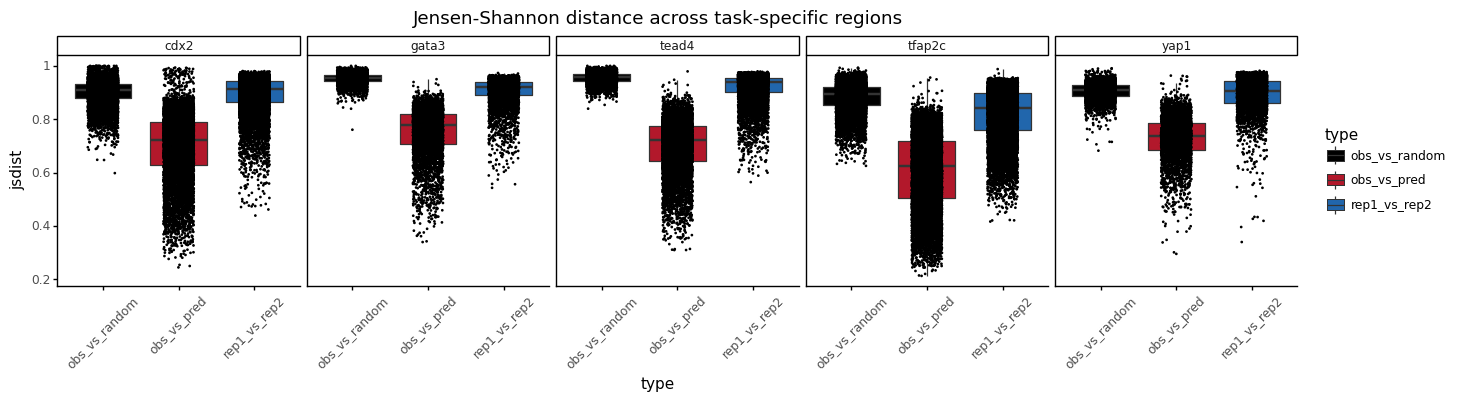

In [27]:
plotnine.options.figure_size = (16,3)

jsdist_df['type'] = pd.Categorical(jsdist_df['type'], categories=['obs_vs_random', 'obs_vs_pred', 'rep1_vs_rep2'], ordered=False)

jsdist_plot = (ggplot(data = jsdist_df, mapping = aes(x = 'type', y = 'jsdist'))+
    geom_boxplot(mapping = aes(fill = 'type'), outlier_alpha = 0)+
    geom_jitter(width = .2, size = .1)+
    facet_grid('. ~ task')+
    scale_fill_manual(values = ['#000000', '#b2182b', '#2166ac'])+
    ggtitle('Jensen-Shannon distance across task-specific regions')+
    theme_classic()+
    theme(axis_text_x = element_text(angle = 45, hjust = -.5)))
jsdist_plot.save(f'/n/projects/kd2200/publication/bpnet/analysis/figures/2_performance_evaluation/jsdist_valid_regions_fold5.png', height = 3, width = 16)
print(jsdist_plot)